In [1]:
%%capture
!pip install seqeval

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.preprocessing import text, sequence

import tensorflow as tf
from keras import backend as K
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda, Layer
from tensorflow.keras.utils import plot_model
from keras.optimizers import SGD, Adam, RMSprop

from seqeval.metrics import classification_report, f1_score, accuracy_score
from seqeval.scheme import IOB2

## Import Data

In [2]:
raw_data = pd.read_csv('../input/entity-annotated-corpus/ner_dataset.csv', encoding = "ISO-8859-1")
raw_data

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O


## Preprocessing

In [3]:
data_fillna = raw_data.fillna(method='ffill', axis=0)
data_group = data_fillna.groupby(['Sentence #'],as_index=False
                                )['Word', 'POS', 'Tag'].agg(lambda x: list(x))
data_group.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Sentence #,Word,POS,Tag
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo..."


In [4]:
sequences = data_group['Word']
entities = data_group['Tag']

In [5]:
' '.join(sequences[4])

'U.N. relief coordinator Jan Egeland said Sunday , U.S. , Indonesian and Australian military helicopters are ferrying out food and supplies to remote areas of western Aceh province that ground crews can not reach .'

In [6]:
for word, ent in zip(sequences[4], entities[4]):
    print(f'{word:{12}} {ent:{10}}')

U.N.         B-geo     
relief       O         
coordinator  O         
Jan          B-per     
Egeland      I-per     
said         O         
Sunday       B-tim     
,            O         
U.S.         B-geo     
,            O         
Indonesian   B-gpe     
and          O         
Australian   B-gpe     
military     O         
helicopters  O         
are          O         
ferrying     O         
out          O         
food         O         
and          O         
supplies     O         
to           O         
remote       O         
areas        O         
of           O         
western      O         
Aceh         B-geo     
province     O         
that         O         
ground       O         
crews        O         
can          O         
not          O         
reach        O         
.            O         


In [7]:
len(sequences)

47959

In [8]:
def tokens_tags(data_X, data_y):
    i=0
    vocab = []
    labels_map = {}
    for seq in data_X:
        for word in np.unique(seq):
            if word.lower() not in vocab:
                vocab.append(word.lower())
                
    for seq_tags in data_y:
        for tag in seq_tags:
            if tag not in labels_map.keys():
                i+=1
                labels_map[tag] = i
                
    return len(vocab), labels_map, max([len(s) for s in data_X])

num_tokens, labels_map, MAXLEN = tokens_tags(sequences, entities)
print('Number of unique tokens in data ', num_tokens)
print('Max length of sequence in data ', MAXLEN)
print('Number of unique tags in data ', len(labels_map))

Number of unique tokens in data  31817
Max length of sequence in data  104
Number of unique tags in data  17


In [9]:
labels_map['[PAD]'] = 0
labels_map

{'O': 1,
 'B-geo': 2,
 'B-gpe': 3,
 'B-tim': 4,
 'B-org': 5,
 'I-geo': 6,
 'B-per': 7,
 'I-per': 8,
 'I-org': 9,
 'I-tim': 10,
 'B-art': 11,
 'I-art': 12,
 'B-nat': 13,
 'I-gpe': 14,
 'I-nat': 15,
 'B-eve': 16,
 'I-eve': 17,
 '[PAD]': 0}

In [10]:
def data_words(data_X):
    vocab = []
    for seq in data_X:
        for word in seq:
            vocab.append(word)
                
    return len(vocab)

num_words = data_words(sequences)
print('Number of words  in data ', num_words)

Number of words  in data  1048575


## Encoding

In [11]:
def encode_pad_data():
    tokenizer = text.Tokenizer(num_words=num_tokens+1, lower=True)
    tokenizer.fit_on_texts(sequences)    
    encoded_sequences = tokenizer.texts_to_sequences(sequences)
    
    encoded_entities = [[labels_map[i] for i in entity] for entity in entities]
    
    pad_X = sequence.pad_sequences(encoded_sequences, dtype='long', maxlen=MAXLEN, padding='post', value=0.0)
    pad_y = sequence.pad_sequences(encoded_entities, maxlen=MAXLEN, dtype='long', padding='post', value=0.0)
            
    pad_y_ohe = [to_categorical(l, num_classes=len(labels_map)) for l in pad_y]

    return pad_X, pad_y_ohe, tokenizer

pad_X, pad_y, tokenizer = encode_pad_data()

In [12]:
np.array(pad_X).shape, np.array(pad_y).shape

((47959, 104), (47959, 104, 18))

## Train Test Split

In [13]:
from sklearn.model_selection import train_test_split
train_inputs, test_inputs, train_targets, test_targets = train_test_split(pad_X, pad_y, test_size=0.2, random_state=42)

In [14]:
train_inputs = tf.cast(train_inputs, tf.float32) 
test_inputs = tf.cast(test_inputs, tf.float32)
train_targets = tf.cast(train_targets, tf.float32)
test_targets = tf.cast(test_targets, tf.float32)

In [15]:
print(train_targets.shape)
print(test_targets.shape)
print(test_inputs.shape)
print(train_inputs.shape)

(38367, 104, 18)
(9592, 104, 18)
(9592, 104)
(38367, 104)


In [16]:
def mask(m, q):
    mask = tf.math.reduce_any(tf.not_equal(m, q), axis=-1)
    return mask

def recall(y_true, y_pred):
    pad = tf.constant([1]+[0]*(len(labels_map)-1), dtype=tf.float32)
    mask_ = mask(y_true, pad)
    masked_y_true = tf.boolean_mask(y_true, mask_)
    masked_y_pred = tf.boolean_mask(y_pred, mask_)
    true_positives = K.sum(K.round(K.clip(masked_y_true * masked_y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(masked_y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    pad = tf.constant([1]+[0]*(len(labels_map)-1), dtype=tf.float32)
    mask_ = mask(y_true, pad)
    masked_y_true = tf.boolean_mask(y_true, mask_)
    masked_y_pred = tf.boolean_mask(y_pred, mask_)
    true_positives = K.sum(K.round(K.clip(masked_y_true * masked_y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(masked_y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    precision_ = precision(y_true, y_pred)
    recall_ = recall(y_true, y_pred)
    return 2*((precision_*recall_)/(precision_+recall_+K.epsilon()))

## BiLSTM Model

In [17]:
#Now train the model
opt = Adam(0.01)
output_dim = 64
emb_dim = 300
tf.random.set_seed(42)

sequence_input = Input(shape=(MAXLEN,), dtype=tf.int32, name='sequence_input')
outputs = Embedding(input_dim=num_tokens+1, output_dim=emb_dim, trainable=True, mask_zero=True)(sequence_input)
outputs = Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5), merge_mode = 'concat')(outputs)
outputs = LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)(outputs)
outputs = (Dense(len(labels_map), activation="softmax"))(outputs)

validation_model = Model(inputs=sequence_input, outputs=outputs)
validation_model.compile(loss='CategoricalCrossentropy', optimizer=opt, metrics=[f1, precision, recall])
validation_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence_input (InputLayer)  [(None, 104)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 104, 300)          9545400   
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 128)          186880    
_________________________________________________________________
lstm_1 (LSTM)                (None, 104, 64)           49408     
_________________________________________________________________
dense (Dense)                (None, 104, 18)           1170      
Total params: 9,782,858
Trainable params: 9,782,858
Non-trainable params: 0
_________________________________________________________________


The training here is done on CPU because i GPU quota was over

In [18]:
his = validation_model.fit(train_inputs, train_targets, epochs=10, batch_size=256, validation_split=0.1)

Epoch 1/10
135/135 [==============================] - 253s 2s/step - loss: 0.1655 - f1: 0.7966 - precision: 0.8326 - recall: 0.7673 - val_loss: 0.0414 - val_f1: 0.9471 - val_precision: 0.9614 - val_recall: 0.9332
Epoch 2/10
135/135 [==============================] - 237s 2s/step - loss: 0.0346 - f1: 0.9553 - precision: 0.9653 - recall: 0.9455 - val_loss: 0.0303 - val_f1: 0.9585 - val_precision: 0.9644 - val_recall: 0.9528
Epoch 3/10
135/135 [==============================] - 239s 2s/step - loss: 0.0235 - f1: 0.9675 - precision: 0.9726 - recall: 0.9623 - val_loss: 0.0295 - val_f1: 0.9591 - val_precision: 0.9636 - val_recall: 0.9546
Epoch 4/10
135/135 [==============================] - 234s 2s/step - loss: 0.0205 - f1: 0.9712 - precision: 0.9753 - recall: 0.9671 - val_loss: 0.0293 - val_f1: 0.9613 - val_precision: 0.9649 - val_recall: 0.9577
Epoch 5/10
135/135 [==============================] - 233s 2s/step - loss: 0.0183 - f1: 0.9734 - precision: 0.9771 - recall: 0.9699 - val_loss: 0.02

In [19]:
embed_size=300

EMBEDDING_FILE = '../input/glove840b300dtxt/glove.840B.300d.txt'

embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
word_index = tokenizer.word_index
embedding_matrix = np.zeros((num_tokens+1, embed_size))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [20]:
opt = Adam(0.01)
output_dim = 64
tf.random.set_seed(42)

sequence_input = Input(shape=(MAXLEN,), dtype=tf.int32, name='sequence_input')
outputs = Embedding(input_dim=num_tokens+1, output_dim=embed_size, weights=[embedding_matrix], trainable=True, mask_zero=True)(sequence_input)
outputs = Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5), merge_mode = 'concat')(outputs)
outputs = LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)(outputs)
outputs = (Dense(len(labels_map), activation="softmax"))(outputs)

validation_glove_model = Model(inputs=sequence_input, outputs=outputs)
validation_glove_model.compile(loss='CategoricalCrossentropy', optimizer=opt, metrics=[f1, precision, recall])
validation_glove_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence_input (InputLayer)  [(None, 104)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 104, 300)          9545400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 104, 128)          186880    
_________________________________________________________________
lstm_3 (LSTM)                (None, 104, 64)           49408     
_________________________________________________________________
dense_1 (Dense)              (None, 104, 18)           1170      
Total params: 9,782,858
Trainable params: 9,782,858
Non-trainable params: 0
_________________________________________________________________


In [21]:
glove_his = validation_glove_model.fit(train_inputs, train_targets, epochs=10, batch_size=256, validation_split=0.1)

Epoch 1/10
135/135 [==============================] - 248s 2s/step - loss: 0.1259 - f1: 0.8266 - precision: 0.9014 - recall: 0.7901 - val_loss: 0.0325 - val_f1: 0.9555 - val_precision: 0.9636 - val_recall: 0.9475
Epoch 2/10
135/135 [==============================] - 240s 2s/step - loss: 0.0300 - f1: 0.9600 - precision: 0.9677 - recall: 0.9525 - val_loss: 0.0276 - val_f1: 0.9616 - val_precision: 0.9664 - val_recall: 0.9568
Epoch 3/10
135/135 [==============================] - 237s 2s/step - loss: 0.0231 - f1: 0.9677 - precision: 0.9727 - recall: 0.9627 - val_loss: 0.0271 - val_f1: 0.9624 - val_precision: 0.9662 - val_recall: 0.9587
Epoch 4/10
135/135 [==============================] - 239s 2s/step - loss: 0.0203 - f1: 0.9708 - precision: 0.9750 - recall: 0.9667 - val_loss: 0.0274 - val_f1: 0.9633 - val_precision: 0.9660 - val_recall: 0.9606
Epoch 5/10
135/135 [==============================] - 236s 2s/step - loss: 0.0186 - f1: 0.9729 - precision: 0.9765 - recall: 0.9694 - val_loss: 0.02

## Results

In [22]:
loss = [his.history['loss'], 'Training Loss']
f1 = [his.history['f1'], 'Training F1']
val_loss = [his.history['val_loss'], 'Validation Loss']
val_f1 = [his.history['val_f1'], 'Validation F1']
val_precision = [his.history['val_precision'], 'Validation Precision']
precision = [his.history['precision'], 'Training Precision']
recall = [his.history['recall'], 'Training Recall']
val_recall = [his.history['val_recall'], 'Validation Recall']

glove_loss = [glove_his.history['loss'], 'Training Loss']
glove_f1 = [glove_his.history['f1'], 'Training F1']
glove_val_loss = [glove_his.history['val_loss'], 'Validation Loss']
glove_val_f1 = [glove_his.history['val_f1'], 'Validation F1']
glove_val_precision = [glove_his.history['val_precision'], 'Validation Precision']
glove_precision = [glove_his.history['precision'], 'Training Precision']
glove_recall = [glove_his.history['recall'], 'Training Recall']
glove_val_recall = [glove_his.history['val_recall'], 'Validation Recall']

In [23]:
def make_plot(metric1, val_metric1, metric2, val_metric2, ylabel):
    epochs = range(1, 11)
    xint = range(min(epochs), math.ceil(max(epochs))+1)

    plt.figure(figsize=(25,15))
    plt.plot(epochs, metric1[0],  label="BiLSTM "+metric1[1], linewidth=4, c="#0000FF", )
    plt.plot(epochs, val_metric1[0], label="BiLSTM "+val_metric1[1], linewidth=4, c="#FFA500")
    plt.plot(epochs, metric2[0],  label="BiLSTM-GloVe "+metric2[1], linewidth=4, c="#0000FF", linestyle='dashed')
    plt.plot(epochs, val_metric2[0], label="BiLSTM-GloVe "+val_metric2[1], linewidth=4, c="#FFA500", linestyle='dashed')
    plt.xlabel('Epochs', fontsize=50)
    plt.ylabel(ylabel, fontsize=50)
    plt.legend(fontsize=50)
    plt.xticks(xint, fontsize=50)
    plt.yticks(fontsize=50)
    plt.grid()
    plt.tight_layout()
    plt.savefig(metric1[1]+'.pdf')
    plt.show()

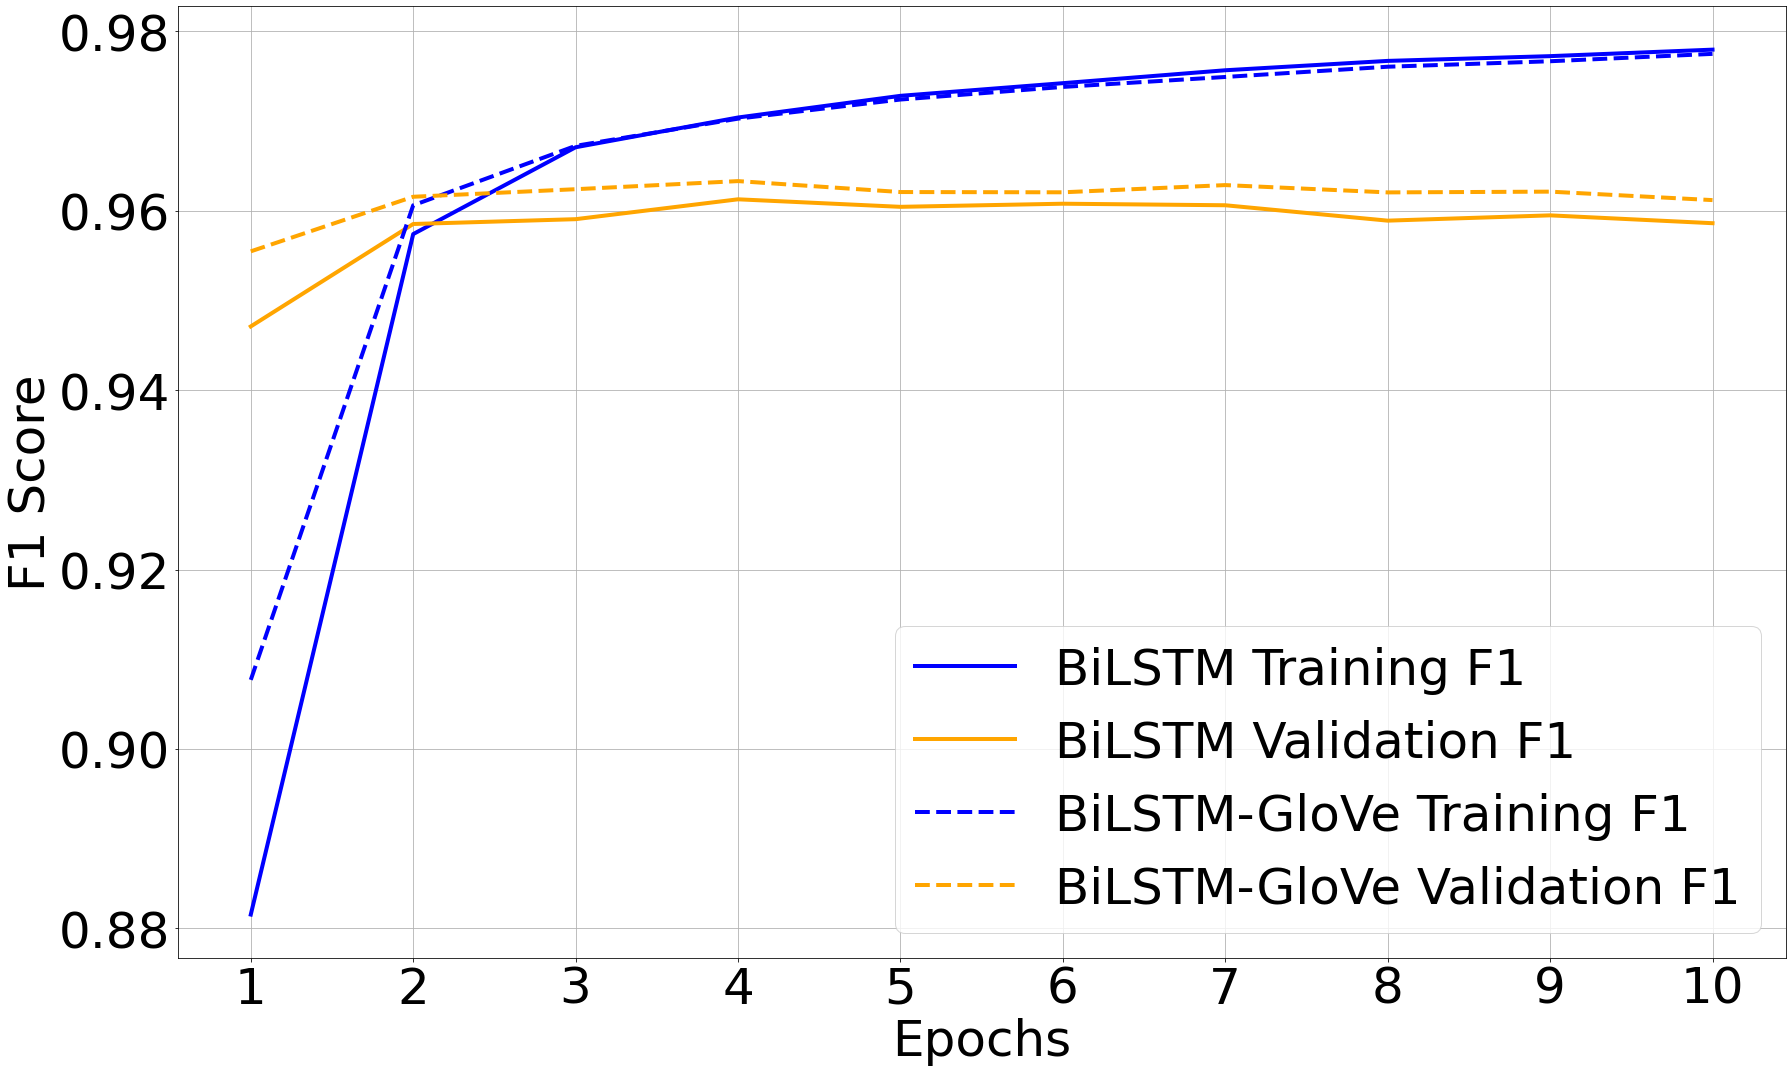

In [24]:
make_plot(f1, val_f1, glove_f1,glove_val_f1, 'F1 Score')

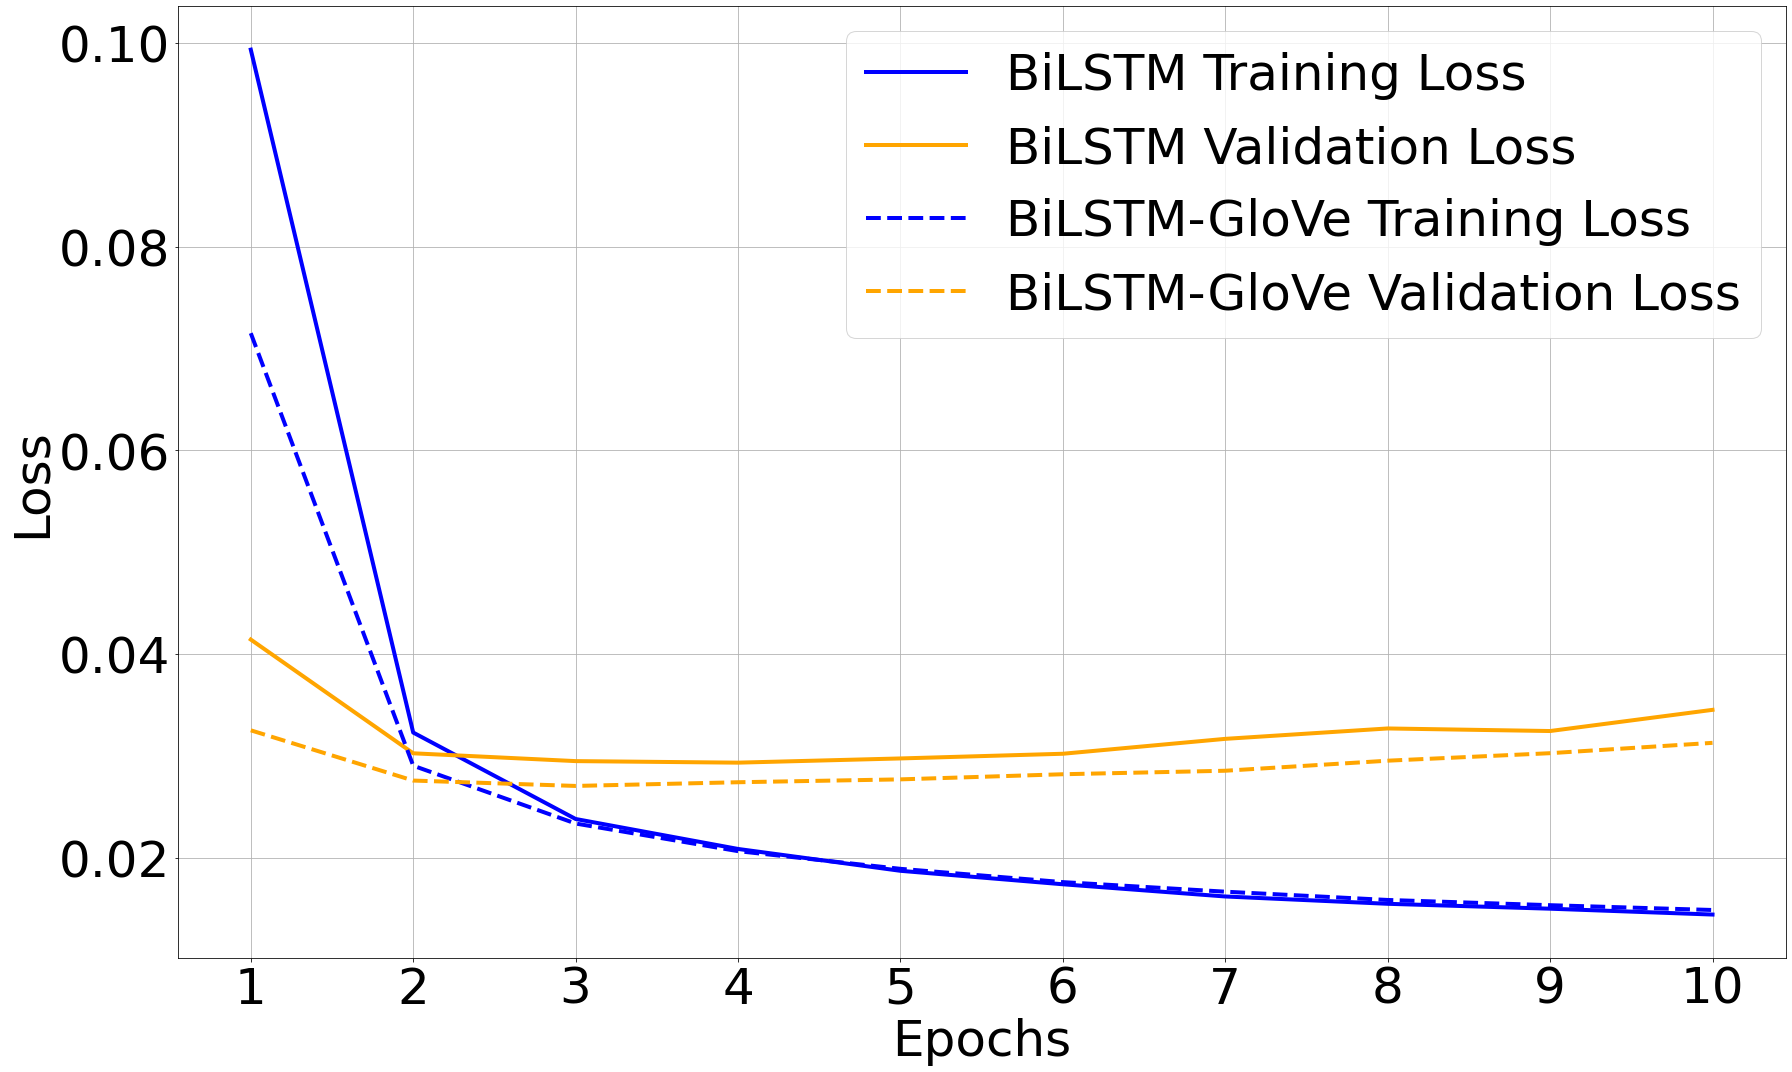

In [25]:
make_plot(loss, val_loss, glove_loss, glove_val_loss, 'Loss')

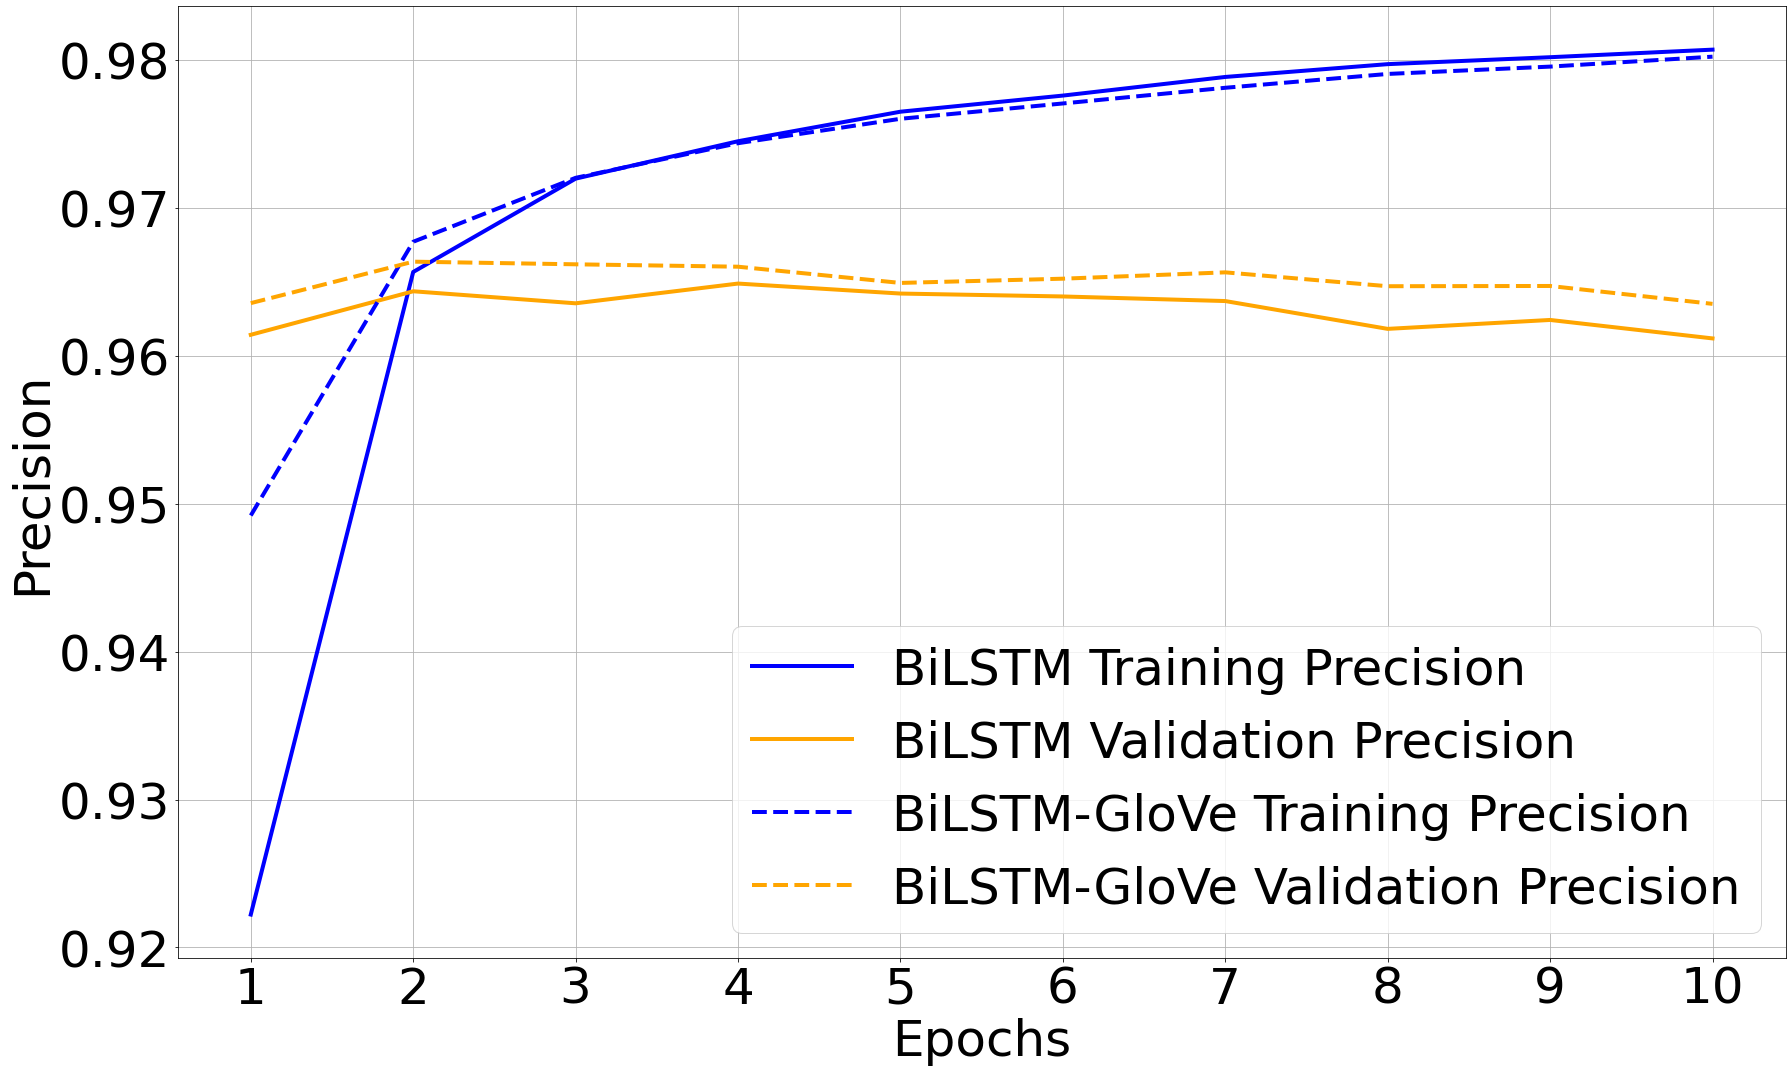

In [26]:
make_plot(precision, val_precision, glove_precision,glove_val_precision, 'Precision')

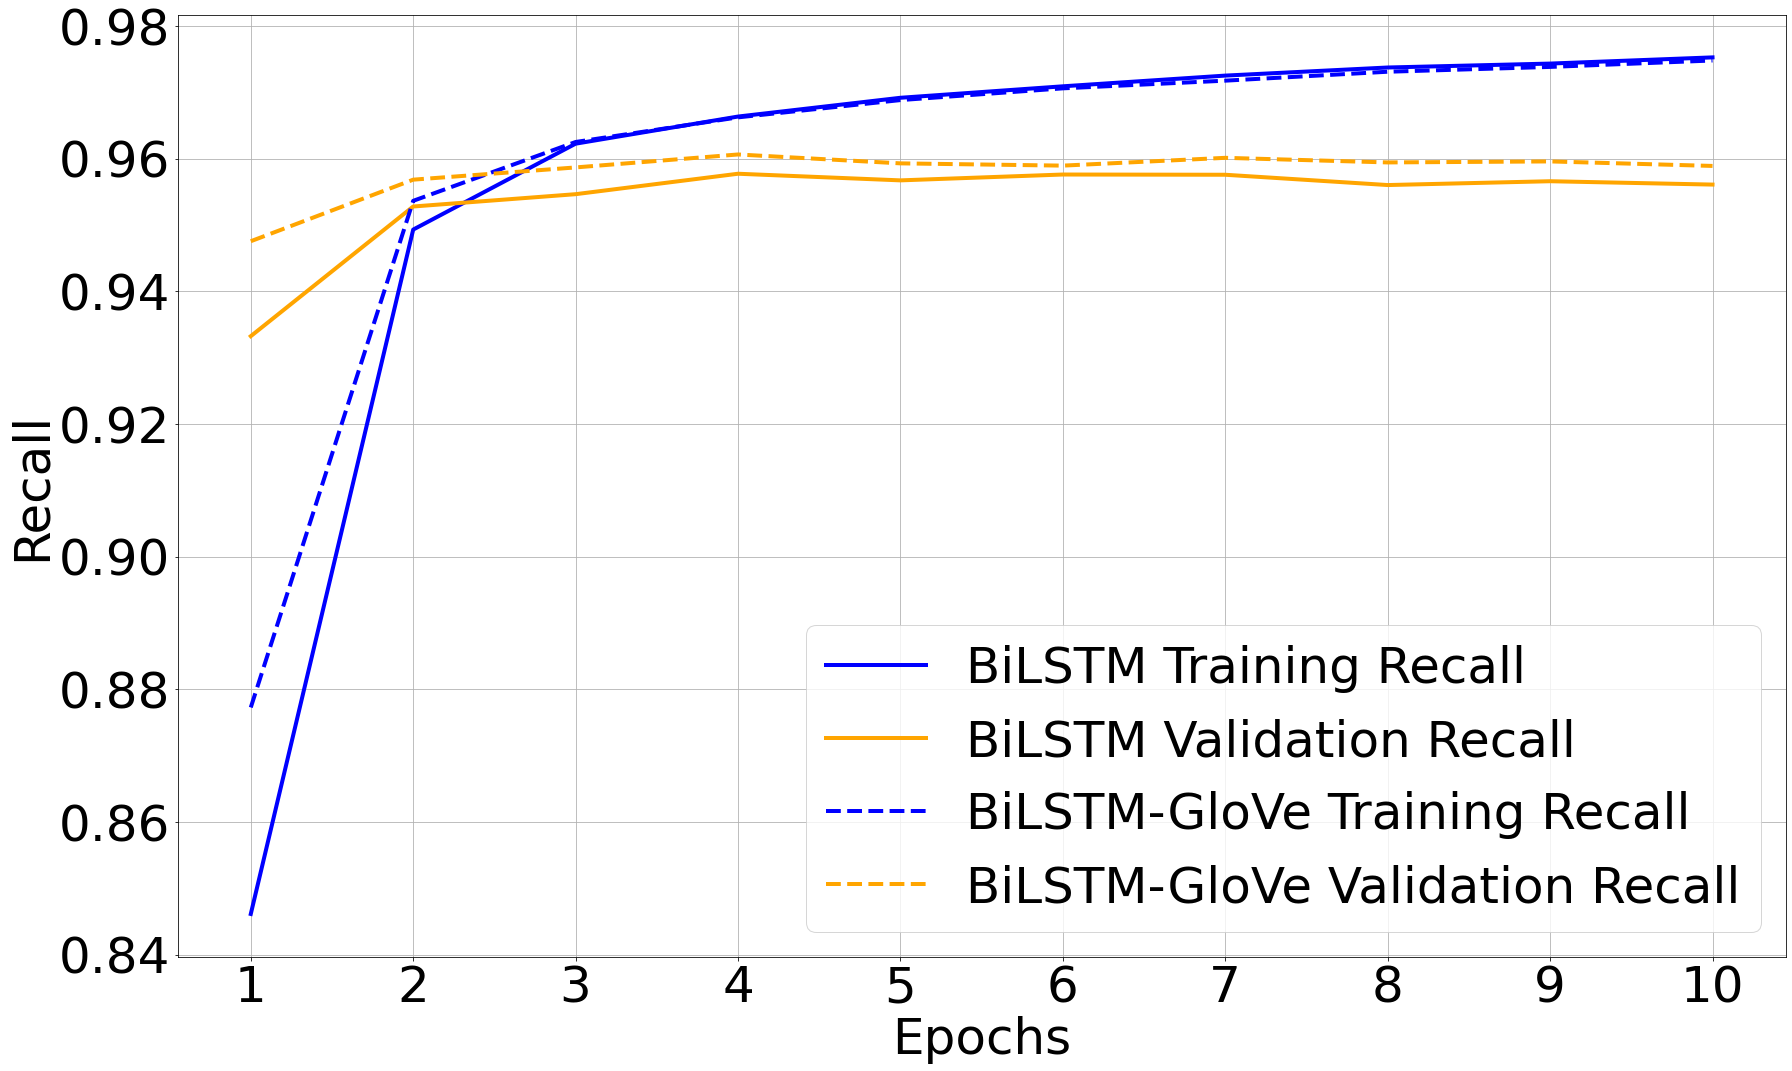

In [27]:
make_plot(recall, val_recall, glove_recall,glove_val_recall, 'Recall')

# Final Models

In [28]:
def mask(m, q):
    mask = tf.math.reduce_any(tf.not_equal(m, q), axis=-1)
    return mask

def recall(y_true, y_pred):
    pad = tf.constant([1]+[0]*(len(labels_map)-1), dtype=tf.float32)
    mask_ = mask(y_true, pad)
    masked_y_true = tf.boolean_mask(y_true, mask_)
    masked_y_pred = tf.boolean_mask(y_pred, mask_)
    true_positives = K.sum(K.round(K.clip(masked_y_true * masked_y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(masked_y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    pad = tf.constant([1]+[0]*(len(labels_map)-1), dtype=tf.float32)
    mask_ = mask(y_true, pad)
    masked_y_true = tf.boolean_mask(y_true, mask_)
    masked_y_pred = tf.boolean_mask(y_pred, mask_)
    true_positives = K.sum(K.round(K.clip(masked_y_true * masked_y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(masked_y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    precision_ = precision(y_true, y_pred)
    recall_ = recall(y_true, y_pred)
    return 2*((precision_*recall_)/(precision_+recall_+K.epsilon()))

In [29]:
tf.random.set_seed(42)

sequence_input = Input(shape=(MAXLEN,), dtype=tf.int32, name='sequence_input')
outputs = Embedding(input_dim=num_tokens+1, output_dim=emb_dim, trainable=True, mask_zero=True)(sequence_input)
outputs = Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5), merge_mode = 'concat')(outputs)
outputs = LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)(outputs)
outputs = (Dense(len(labels_map), activation="softmax"))(outputs)

final_model = Model(inputs=sequence_input, outputs=outputs)
final_model.compile(loss='CategoricalCrossentropy', optimizer=opt, metrics=[f1, precision, recall])
final_model.fit(train_inputs, train_targets, epochs=10, batch_size=256)

Epoch 1/10
150/150 [==============================] - 273s 2s/step - loss: 0.1484 - f1: 0.8194 - precision: 0.8503 - recall: 0.7919
Epoch 2/10
150/150 [==============================] - 258s 2s/step - loss: 0.0464 - f1: 0.9431 - precision: 0.9596 - recall: 0.9271
Epoch 3/10
150/150 [==============================] - 266s 2s/step - loss: 0.0364 - f1: 0.9532 - precision: 0.9636 - recall: 0.9430
Epoch 4/10
150/150 [==============================] - 255s 2s/step - loss: 0.0312 - f1: 0.9585 - precision: 0.9660 - recall: 0.9511
Epoch 5/10
150/150 [==============================] - 257s 2s/step - loss: 0.0282 - f1: 0.9614 - precision: 0.9679 - recall: 0.9549
Epoch 6/10
150/150 [==============================] - 261s 2s/step - loss: 0.0262 - f1: 0.9639 - precision: 0.9697 - recall: 0.9581
Epoch 7/10
150/150 [==============================] - 260s 2s/step - loss: 0.0247 - f1: 0.9655 - precision: 0.9709 - recall: 0.9601
Epoch 8/10
150/150 [==============================] - 259s 2s/step - loss: 0

In [30]:
tf.random.set_seed(42)

sequence_input = Input(shape=(MAXLEN,), dtype=tf.int32, name='sequence_input')
outputs = Embedding(input_dim=num_tokens+1, output_dim=embed_size, weights=[embedding_matrix], trainable=True, mask_zero=True)(sequence_input)
outputs = Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5), merge_mode = 'concat')(outputs)
outputs = LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)(outputs)
outputs = (Dense(len(labels_map), activation="softmax"))(outputs)

final_glove_model = Model(inputs=sequence_input, outputs=outputs)
final_glove_model.compile(loss='CategoricalCrossentropy', optimizer=opt, metrics=[f1, precision, recall])
final_glove_model.fit(train_inputs, train_targets, epochs=10, batch_size=256)

Epoch 1/10
150/150 [==============================] - 270s 2s/step - loss: 0.1120 - f1: 0.8600 - precision: 0.9141 - recall: 0.8177
Epoch 2/10
150/150 [==============================] - 258s 2s/step - loss: 0.0379 - f1: 0.9509 - precision: 0.9619 - recall: 0.9401
Epoch 3/10
150/150 [==============================] - 257s 2s/step - loss: 0.0311 - f1: 0.9585 - precision: 0.9662 - recall: 0.9510
Epoch 4/10
150/150 [==============================] - 260s 2s/step - loss: 0.0276 - f1: 0.9626 - precision: 0.9687 - recall: 0.9565
Epoch 5/10
150/150 [==============================] - 262s 2s/step - loss: 0.0258 - f1: 0.9641 - precision: 0.9695 - recall: 0.9587
Epoch 6/10
150/150 [==============================] - 265s 2s/step - loss: 0.0246 - f1: 0.9656 - precision: 0.9708 - recall: 0.9604
Epoch 7/10
150/150 [==============================] - 260s 2s/step - loss: 0.0235 - f1: 0.9669 - precision: 0.9717 - recall: 0.9622
Epoch 8/10
150/150 [==============================] - 265s 2s/step - loss: 0

## Test Data Evaluation

In [31]:
final_model.evaluate(test_inputs, test_targets)

300/300 [==============================] - 25s 78ms/step - loss: 0.0317 - f1: 0.9609 - precision: 0.9643 - recall: 0.9575


[0.031670860946178436,
 0.9608533382415771,
 0.9642803072929382,
 0.9574560523033142]

In [32]:
final_glove_model.evaluate(test_inputs, test_targets)

300/300 [==============================] - 24s 78ms/step - loss: 0.0285 - f1: 0.9627 - precision: 0.9658 - recall: 0.9595


[0.028484636917710304,
 0.9626522064208984,
 0.9658160209655762,
 0.959514856338501]

In [33]:
test_pred = np.array(final_model.predict(test_inputs))
test_pred = np.argmax(test_pred, axis=-1)
test_true = np.argmax(test_targets, axis=-1)
test_true = np.array(test_true)

inv_label_map = {v: k for k, v in labels_map.items()}

for_report_true_labels = [[inv_label_map[label] for label in t_labels if label != 0] 
                          for t_labels in test_true]
for_report_pred_labels = [[inv_label_map[test_pred[i][j]] for j, label in enumerate(t_labels) 
                           if label != 0] for i, t_labels in enumerate(test_true)]
print(classification_report(for_report_true_labels, for_report_pred_labels, 
                            digits=3, mode='strict', scheme=IOB2))

              precision    recall  f1-score   support

         art      0.375     0.032     0.059        94
         eve      0.516     0.229     0.317        70
         geo      0.841     0.858     0.849      7558
         gpe      0.961     0.936     0.949      3142
         nat      0.316     0.300     0.308        40
         org      0.692     0.553     0.615      4151
         per      0.744     0.716     0.729      3400
         tim      0.877     0.829     0.852      4077

   micro avg      0.825     0.779     0.801     22532
   macro avg      0.665     0.556     0.585     22532
weighted avg      0.818     0.779     0.796     22532



In [34]:
test_pred = np.array(final_glove_model.predict(test_inputs))
test_pred = np.argmax(test_pred, axis=-1)
test_true = np.argmax(test_targets, axis=-1)
test_true = np.array(test_true)

inv_label_map = {v: k for k, v in labels_map.items()}

for_report_true_labels = [[inv_label_map[label] for label in t_labels if label != 0] 
                          for t_labels in test_true]
for_report_pred_labels = [[inv_label_map[test_pred[i][j]] for j, label in enumerate(t_labels) 
                           if label != 0] for i, t_labels in enumerate(test_true)]

print(classification_report(for_report_true_labels, for_report_pred_labels, 
                            digits=3, mode='strict', scheme=IOB2))

/opt/conda/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art      0.000     0.000     0.000        94
         eve      0.789     0.214     0.337        70
         geo      0.842     0.863     0.852      7558
         gpe      0.958     0.941     0.949      3142
         nat      0.000     0.000     0.000        40
         org      0.638     0.599     0.618      4151
         per      0.765     0.752     0.759      3400
         tim      0.864     0.854     0.859      4077

   micro avg      0.815     0.800     0.807     22532
   macro avg      0.607     0.528     0.547     22532
weighted avg      0.808     0.800     0.803     22532



## Confusion matrix

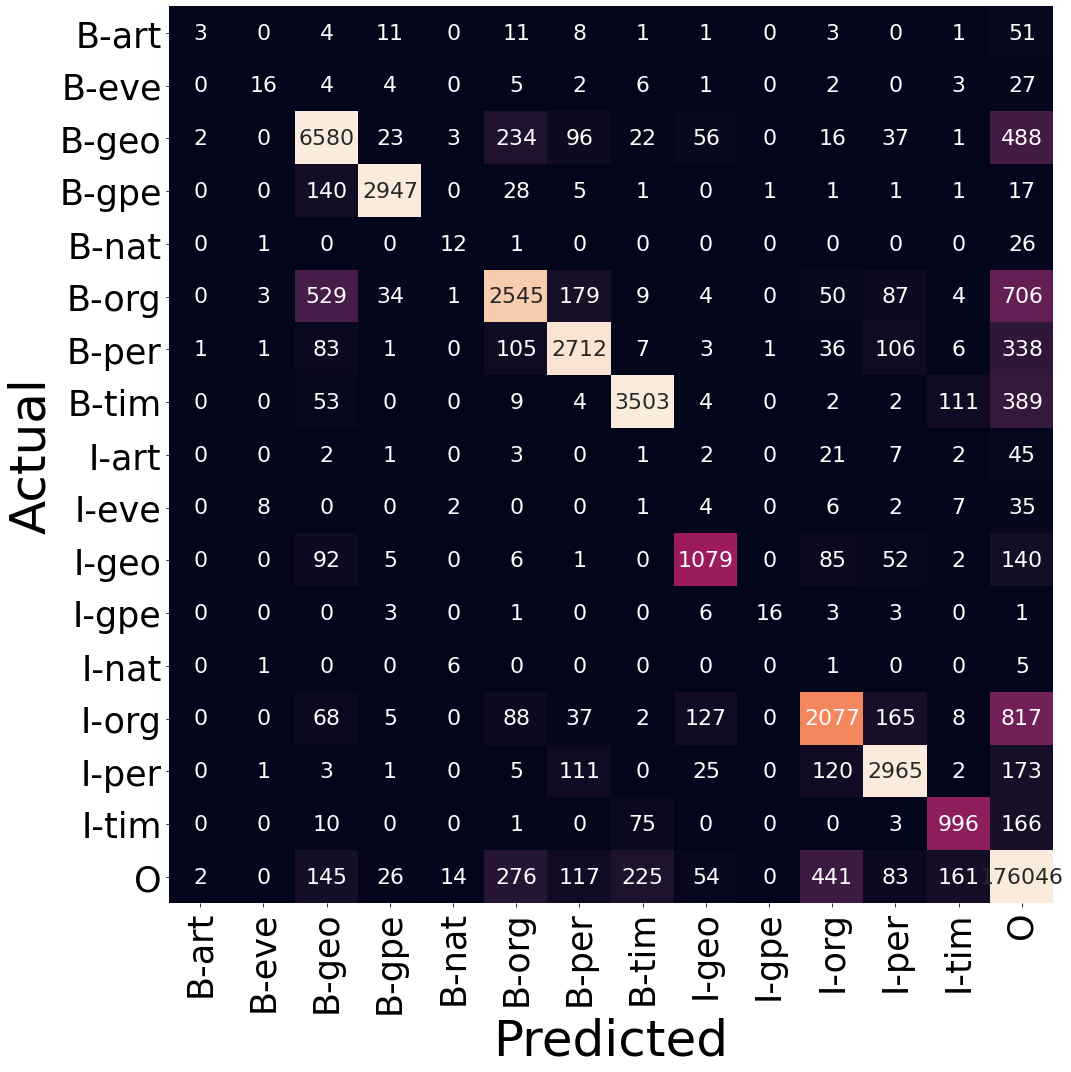

In [35]:
testpred = final_model.predict(test_inputs)

ypred = np.argmax(testpred, axis=-1).flatten()
y = np.argmax(test_targets, axis=-1).flatten()

ytrue, yhat = [], []
for y_t, y_p in zip(y, ypred):
    if y_t != 0:
        ytrue.append(inv_label_map[y_t])
        yhat.append(inv_label_map[y_p])
    
y_actu = pd.Series(ytrue, name='Actual')
y_pred = pd.Series(yhat, name='Predicted')

df_confusion = pd.crosstab(y_actu, y_pred)
plt.figure(figsize=(15,15))
sns.heatmap(df_confusion, annot=True, robust=True, fmt='g', cbar=False, annot_kws={"size": 22})
plt.xlabel('Predicted', fontsize=50)
plt.ylabel('Actual', fontsize=50)
plt.xticks(fontsize=35, rotation=90)
plt.yticks(fontsize=35, rotation=0)
plt.tight_layout()
plt.savefig('conf_matrix.pdf')
plt.show()

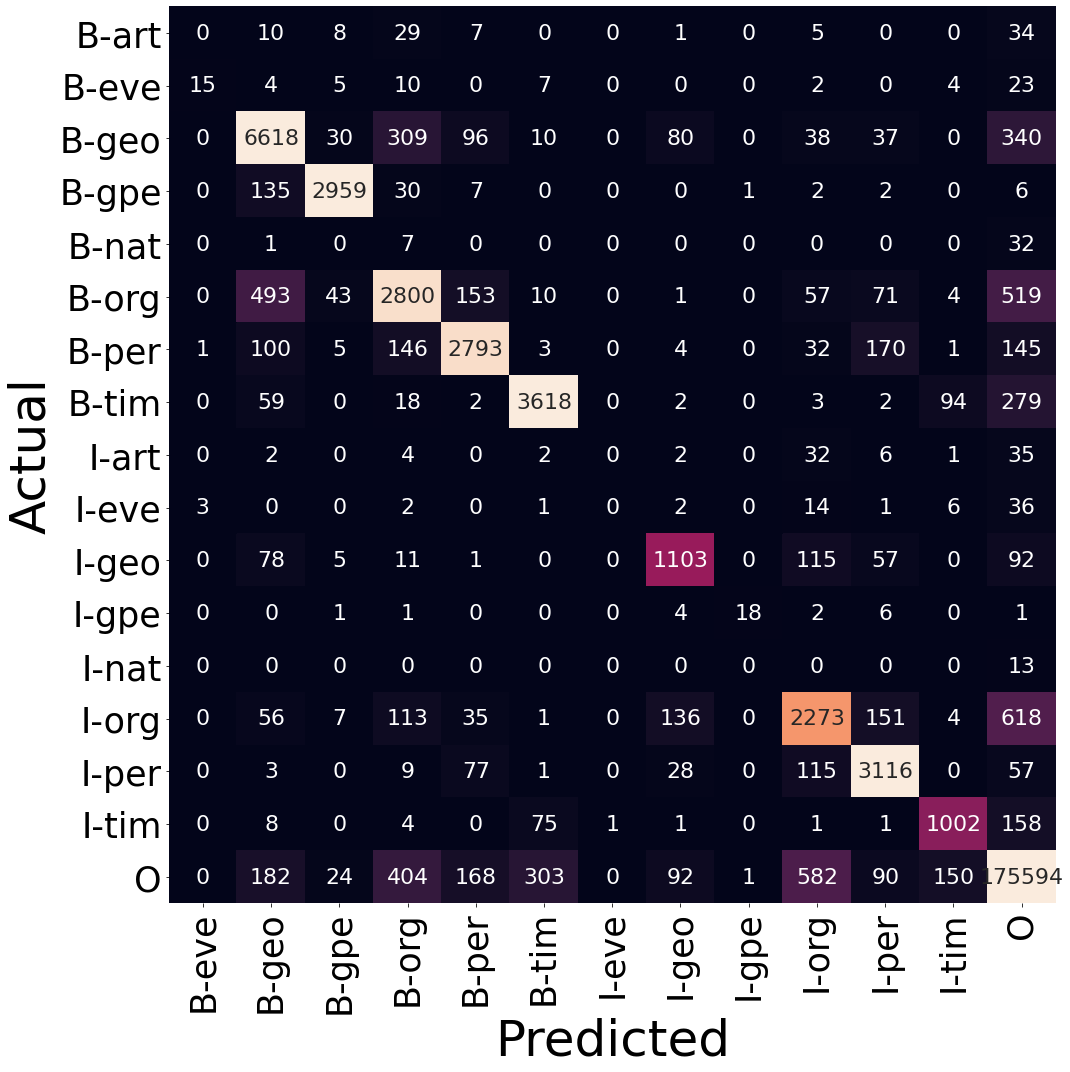

In [36]:
testpred = final_glove_model.predict(test_inputs)

ypred = np.argmax(testpred, axis=-1).flatten()
y = np.argmax(test_targets, axis=-1).flatten()

ytrue, yhat = [], []
for y_t, y_p in zip(y, ypred):
    if y_t != 0:
        ytrue.append(inv_label_map[y_t])
        yhat.append(inv_label_map[y_p])

y_actu = pd.Series(ytrue, name='Actual')
y_pred = pd.Series(yhat, name='Predicted')

df_confusion = pd.crosstab(y_actu, y_pred)
plt.figure(figsize=(15,15))
sns.heatmap(df_confusion, annot=True, robust=True, fmt='g', cbar=False, annot_kws={"size": 22})

plt.xlabel('Predicted', fontsize=50)
plt.ylabel('Actual', fontsize=50)
plt.xticks(fontsize=35, rotation=90)
plt.yticks(fontsize=35, rotation=0)
plt.tight_layout()
plt.savefig('glove_conf_matrix.pdf')
plt.show()

In [37]:
inv_label_map = {v: k for k, v in labels_map.items()}
inv_token_map = tokenizer.index_word

ypred = np.argmax(testpred, axis=-1).flatten()
y = np.argmax(test_targets, axis=-1).flatten()

x = test_inputs[0]
y = y.reshape(9592, 104)[0]
ypred = ypred.reshape(9592, 104)[0]

for x_s, y_t, y_p in zip(x, y, ypred):
    if y_t != 0:
        print(f'{inv_token_map[int(x_s)]:{12}} {inv_label_map[y_t]:{10}} {inv_label_map[y_p]:{10}}')

the          O          O         
report       O          O         
calls        O          O         
on           O          O         
president    B-per      B-per     
bush         I-per      I-per     
and          O          O         
congress     B-org      B-org     
to           O          O         
urge         O          O         
chinese      B-gpe      B-gpe     
officials    O          O         
not          O          O         
to           O          O         
use          O          O         
the          O          O         
global       O          O         
war          O          O         
against      O          O         
terrorism    O          O         
as           O          O         
a            O          O         
pretext      O          O         
to           O          O         
suppress     O          O         
minorities   O          O         
'            O          O         
rights       O          O         
.            O      